In [1]:
#!/usr/bin/env python
# import analyzer
import importlib
from importlib import reload
import os, sys, glob, warnings, glob
import numpy as np
import scipy as sp
import joblib
import ROOT as root

import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

Welcome to JupyROOT 6.24/06


In [187]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis

# 1. Run simulation and tracker
  
    simulation -j2 -o ../fit_study/data/muon_500_GeV -q -s ../fit_study/muon_gun_tom_debug.mac energy 500 count 10
    tracker ../fit_study/data/muon_500_GeV/20230127/175313/run0.root ../fit_study/data/muon_500_GeV/20230127/175313


tracker ../data/w_to_muon/20230129/210801/run0.root ../data/w_to_muon/20230129/210801/

## 2. Basic file operation

* Open a root file
* use "event" class

In [145]:
# 1. filename
muon_energy = 500 #GeV
data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study/w_to_muon"
files=glob.glob(f"{data_dir}/*/210801/stat*.root",)
files.sort(key=os.path.getmtime)
filename = files[-1]
# filename='../../simdata/fit_study/run0.root'
print(files)
print(filename,"\n")

# 2. Open file and print branches
tfile = root.TFile.Open(filename)
tree_name = ["integral_tree","box_run"][0]
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

['/project/def-mdiamond/tomren/mathusla/data/fit_study/w_to_muon/20230129/210801/stat0.root']
/project/def-mdiamond/tomren/mathusla/data/fit_study/w_to_muon/20230129/210801/stat0.root 

['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'G4KLong_code', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_Error

In [146]:
ev = event.Event(filename, 1, tree_name=tree_name)

event_truthtracks=ev.get_truthtrack()
event_vis = ev.get_recon_kalman()

## Plot truth, digi, recon of one event

* vis.plot_truth()
* vis.plot_digi()
* vis.plot_recon()

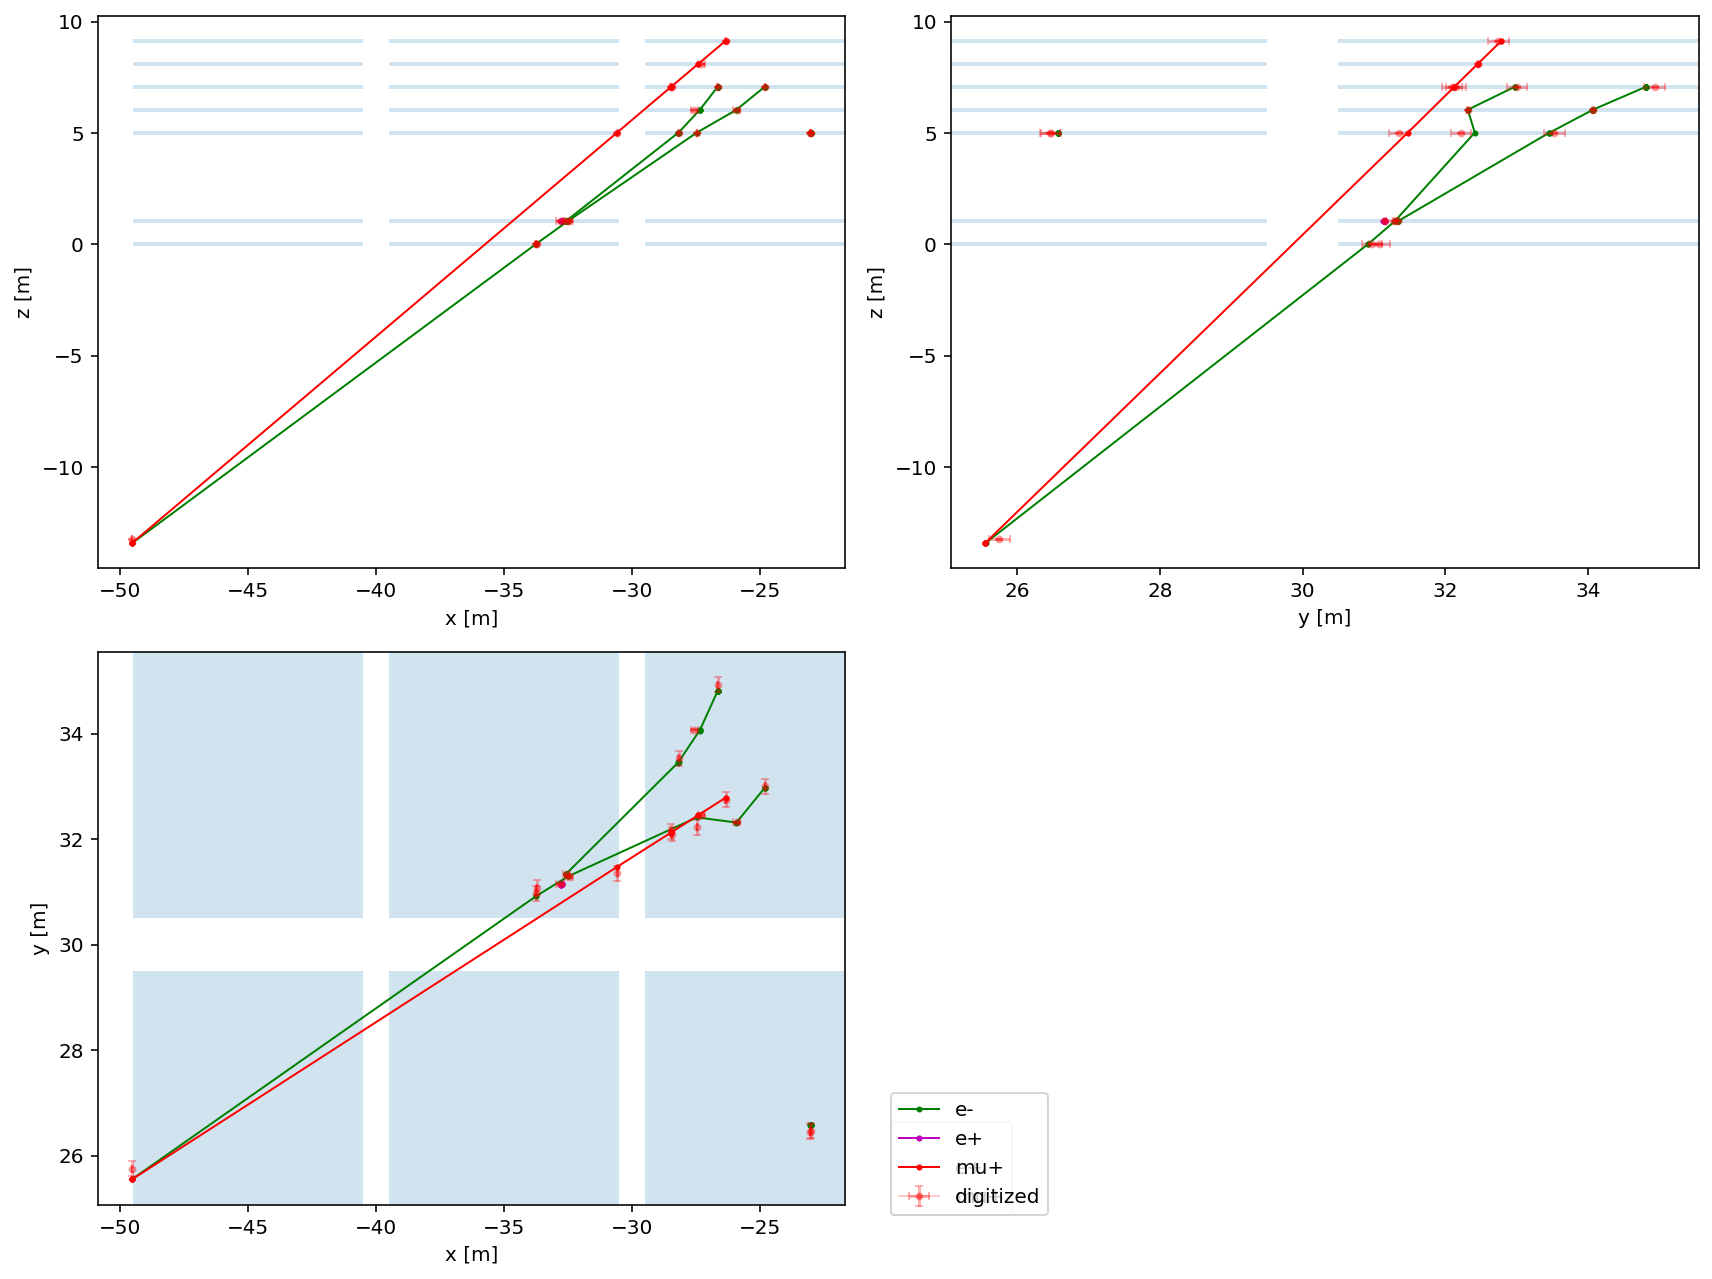

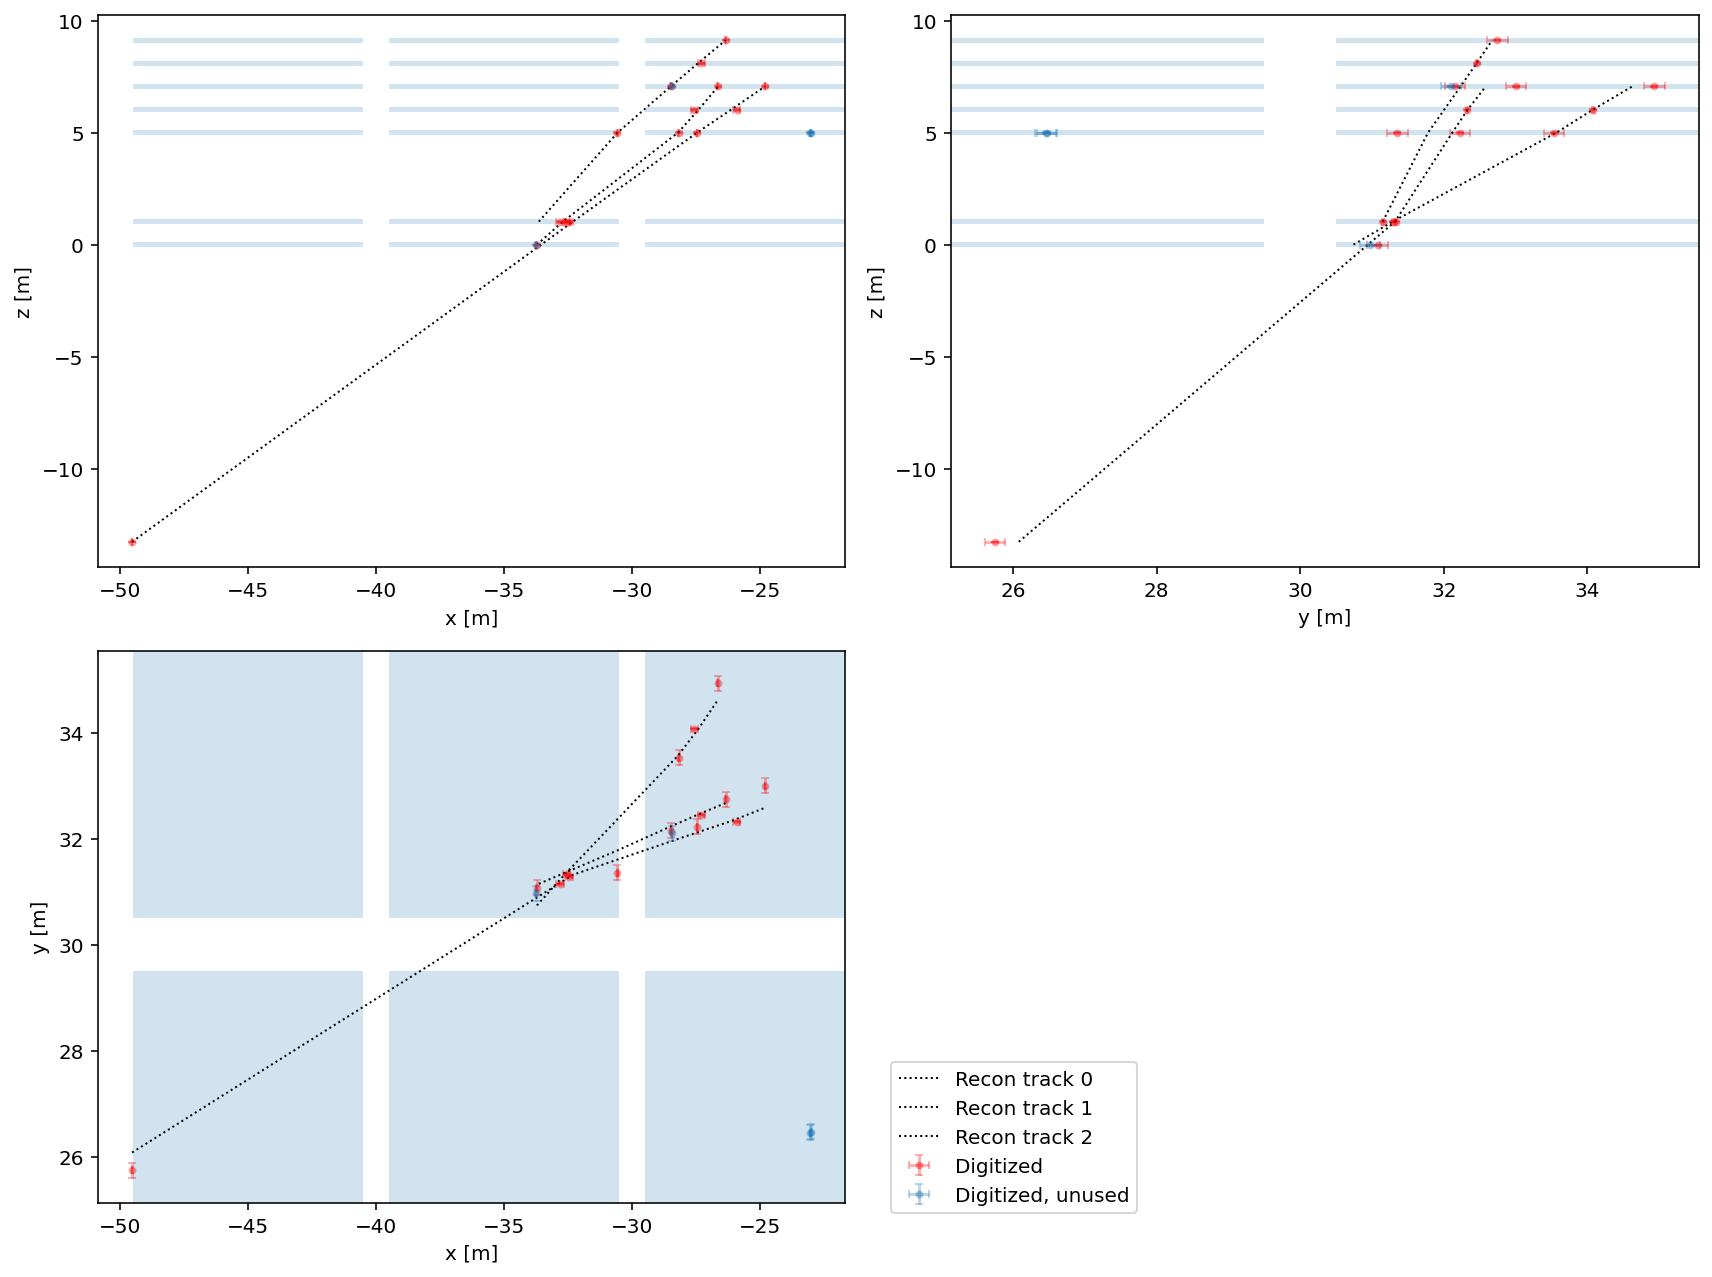

In [191]:
ev.EventNumber=25

# Plot truth+digi
fig,axs=plt.subplots(2,2,figsize=(12,9))
fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
fig = vis.plot_digi(ev,fig=fig, disp_det_view=True);
plt.show()


# Plot truth+recon
fig,axs=plt.subplots(2,2,figsize=(12,9))
# fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=False);
plt.show()

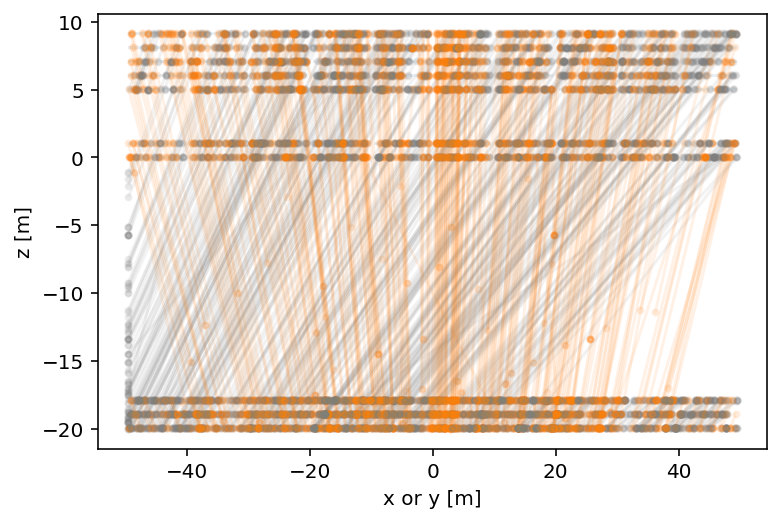

In [8]:
ev = event.Event(filename, 0, tree_name=tree_name)
for i in range(nevents):
# for i in [8,9]:
#     ev = event.Event(filename, i, tree_name=tree_name)
    ev.EventNumber=i

    tracks=ev.get_truthtrack()
    if len(tracks)>0:
        for track in tracks:
            track=util.coord_cms2det(track)
            plt.plot(track[0],track[2],marker=".",color="grey",alpha=0.1)
            plt.plot(track[1],track[2],marker=".",color="C1",alpha=0.1)    
        
    plt.xlabel('x or y [m]')
    plt.ylabel('z [m]')
    
vis.drawdet_xz()

## Plot one track with its Kalman filter reconstruction

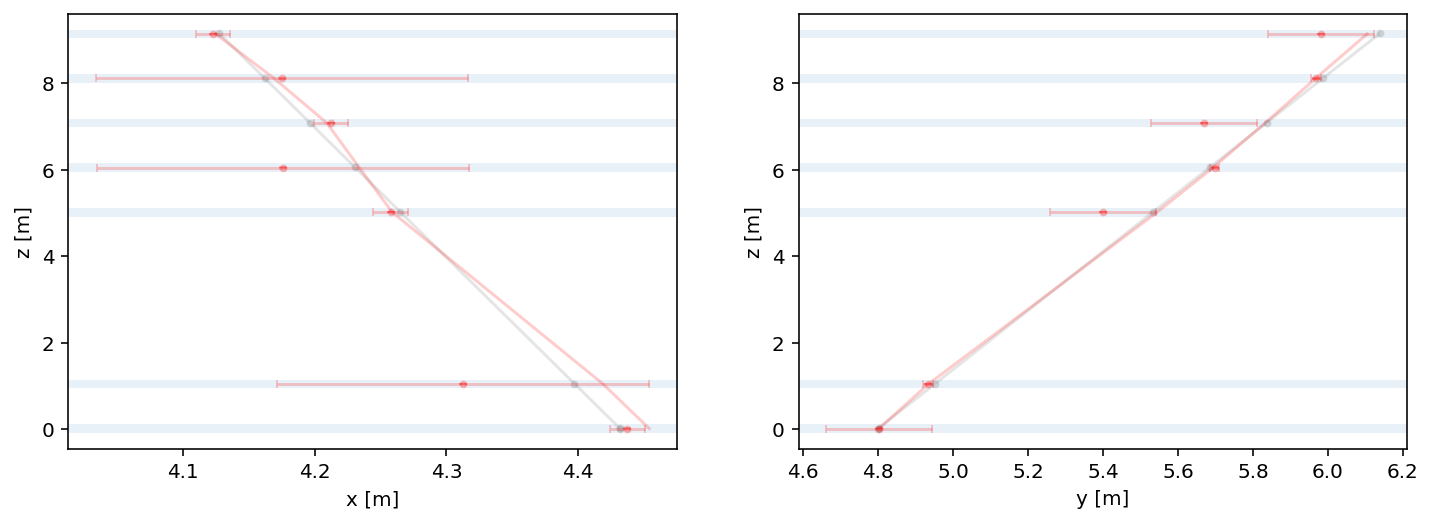

In [126]:
ev = event.Event(filename, 0, tree_name=tree_name)
ev.EventNumber=4
cut=cutflow.sample_space("")

# Get the "truth" tracks, the "digitized" tracks, and the reconstrunction
truthtracks=ev.get_truthtrack()
event_vis = ev.get_recon_kalman()

# Plot x-z, y-z separately
fig,axs=plt.subplots(1,2,figsize=(12,4))
xlabels=["x [m]", "y [m]"]
for i_axis in [0,1]:
    # Plot truth tracks
    if len(truthtracks)>0:
        for track in truthtracks:
            track=util.coord_cms2det(track)
            axs[i_axis].plot(track[i_axis],track[2],marker=".",color="grey",alpha=0.2)

    # Plot reconstructed tracks
    for i_track in range(len(event_vis["track_nonvertex"])):
        # Read the reconstructed track
        track=event_vis["track_nonvertex"][i_track]
        track=util.coord_cms2det(np.array(track))
        hits=[[],[],[]]
        hits_uncertainty=[[],[],[]]
        
        # Read hits of this track
        for i_hit in range(len(track[0])):
            hit=event_vis["hit_nonvertex"][i_track][i_hit]
            hit_layer = cut.in_layer(hit[1])
            hit_uncertainty = np.array(detector.Layer().uncertainty(hit_layer))
            hit=util.coord_cms2det(np.array(hit))
            hit_uncertainty=hit_uncertainty[[2,0,1]]
            for i in range(3):
                hits[i].append(hit[i])
                hits_uncertainty[i].append(hit_uncertainty[i])
        # Plot track and hits
        axs[i_axis].errorbar(hits[i_axis],hits[2],
                             xerr=hits_uncertainty[i_axis],yerr=hits_uncertainty[2],
                             color="red",capsize=2,ls='none',alpha=0.2, fmt=".")
        axs[i_axis].plot(track[i_axis],track[2],color="red",alpha=0.2)
        

    axs[i_axis].set_xlabel(xlabels[i_axis])
    axs[i_axis].set_ylabel('z [m]')
    vis.drawdet_xz(axis=axs[i_axis])


---
Misc

In [121]:
Tree.GetEntry(5);

# print(Tree.Digi_numHits[:10]),len(Tree.Digi_energy)

for i in range(int(Tree.NumHits)):
    print(int(Tree.Hit_G4ParentTrackId[i]), Tree.Hit_particlePdgId[i], Tree.Hit_G4TrackId[i], Tree.Hit_x[i], Tree.Hit_y[i], Tree.Hit_z[i], Tree.Hit_energy[i], Tree.Hit_time[i])

# for i in range(len(Tree.Digi_numHits)):
#     print(Tree.Digi_time[i], Tree.Digi_y[i],Tree.Digi_energy[i], Tree.Digi_particle_energy[i], Tree.Digi_pdg_id[i], Tree.Digi_seed)

0 13.0 1.0 478.19898850123445 8550.556816582624 12433.138780470268 0.09140460092827503 6.943322274804753
0 13.0 1.0 478.3059414584539 8551.328818042359 12433.264450368806 1.4026034711052657 6.969655213637554
0 13.0 1.0 478.4681929054834 8552.5 12433.455104349276 1.9472644663719365 7.009604185057804
0 13.0 1.0 492.73813054262394 8655.5 12450.222217828936 3.5142710404006525 10.522933192311553
0 13.0 1.0 547.5750857617917 9051.33526353804 12514.654313662875 1.315078316816873 24.024829145389067
0 13.0 1.0 547.736438132354 9052.5 12514.84390529965 2.0113612432658177 24.06455816391306
0 13.0 1.0 562.0049980974902 9155.5 12531.610941654713 3.4107135071925074 27.577880535945425
0 13.0 1.0 576.2068761161721 9258.015743925896 12548.29924041598 2.8601247696589 31.074687278518933
0 13.0 1.0 576.2739648725254 9258.5 12548.378076715759 0.9625098693719193 31.09120527041938
0 13.0 1.0 590.3474705754057 9360.078072878548 12564.914813260273 1.0736069899808078 34.55604073113156
0 13.0 1.0 590.50021929743